In [2]:
# importazione librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import Nadam
from timeit import default_timer as timer

# Creazione dei dati sintetici e della matrice ricorrente



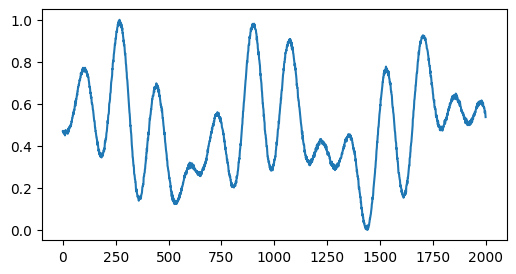

In [3]:
# configurazione parametri per generare un dataset
# utile per essere utilizzato in "sequenze temporali"
n = 2000  # 2000 esempi
test_split_point = 1600 # di cui 400 usati per la validazione del modello

t = np.arange(0, n) # lista di numeri da 0 a 1999

# costruzione del dataset
x = (np.sin(0.008 * t) + np.sin(0.03 * t) - np.sin(0.04 * t)) * 6 + (np.random.rand(n) - np.random.rand(n)) / 2

x_min = min(x)
x_max = max(x)

x = (x - x_min) / (x_max - x_min)

df = pd.DataFrame(x)


# rappresentazione grafica della distribuzione creata
plt.figure(figsize=(6, 3))
plt.plot(df)
plt.show() 


In [4]:
# conversione in array numpy
values = df.values
values.shape

(2000, 1)

In [5]:
# costruzione delle sequenze temporali
step = 100

train_x, train_y = (values[:test_split_point], step)
test_x, test_y = (values[test_split_point:], step)
train_x.shape

(1600, 1)

In [6]:
# Vedi analisi dimensionale sotto
def convert_to_matrix(data, step):

    x, y = [], []

    for i in range(len(data) - step):
        d = i + step  
        x.append(data[i:d,])
        y.append(data[d,])
        
    return np.array(x), np.array(y)

train_x, train_y = convert_to_matrix(values[:test_split_point], step)
test_x, test_y = convert_to_matrix(values[test_split_point:], step)

**Analisi dei dimensionale**

```
for i in range(len(data) - step):
        d = i + step
        x.append(data[i:d,])
        y.append(data[d,])
```

**supponiamo:**
```
- X = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
- N = 10
- step = 3
```


\

**allora abbiamo**

```
(N - step) = 7
Quindi il for andrà da 0 a 6 (compreso)
```

--

**i = 0 (primo)** \
```
d = 3 
x.append([0:3]) -> [0,1,2] 
y.append(data[3]) -> [3]
``` 

--

**i = 1 (secondo)**  \
```
d = 4 
x.append([1:4]) -> [1,2,3] 
y.append(data[4]) -> [4]
```
--
```
...
```
--

**i = 5 (penultimo)** 
```
d = 8 
x.append([5:8]) -> [5,6,7] 
y.append(data[8]) -> [8]
```
--

**i = 6 (ultimo)** 
```
d = 9 
x.append([6:9]) -> [6,7,8] 
y.append(data[9]) -> [9]
```
--

Da cui in questo caso abbiamo
```
- len(ORIGINALE) = N

- len(RICORRENTE) = len(ORIGINALE) - T
```

--


**ACHTUNG!**
Questo è diverso dal caso visto con il notebook sulla SimpleRNN dove avevamo 

len(RICORRENTE) = (N-T+1), mentre qui abbiamo solo (N-T).

\

Questa differenza è dovuta al tipo di problema.

\

In quel caso infatti la label reale l'avevamo come y separata da y, quindi nel nuovo dataset utilizzavamo tutte le X a disposizione e mettevamo come label la Y corrispondente. 

\

In questo caso, invece, il valore da predirre è parte stessa del dataset X, quindi come Y passiamo il valore successivo all'ultimo passato come X.

\

Non possiamo mettere l'ultimo valore quindi, perché non avremmo alrimenti un'etichetta da mettere. L'ultimo valore in questo caso lo utilizziamo solo come etichetta

In [7]:
print('Shape addestramento   x', train_x.shape, '   y', train_y.shape)
print('Shape test            x', test_x.shape, '    y', test_y.shape)

Shape addestramento   x (1500, 100, 1)    y (1500, 1)
Shape test            x (300, 100, 1)     y (300, 1)


# SimpleRNN x 3

In [8]:
# costruzione del modello
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(step, 1), return_sequences=True))
model.add(SimpleRNN(units=64, return_sequences=True))
model.add(SimpleRNN(units=64))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Nadam(), metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100, 64)           4224      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 64)           8256      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23,905
Trainable params: 23,905
Non-traina

**Analisi dei parametri**

\


**INPUT** -> [None, 100, 1]

\

**model.add(SimpleRNN(units=64, input_shape=(step, 1), return_sequences=True))**
``` 
= || W(input) || + || W(ricorrente) || + || b || = 
= (n°input x n°celle) + (n°celle x n°celle) + (n°celle x 1) = 
= 1x64 + 64x64 + 64 
= 4224
```

**OUTPUT** -> [None, 100, 64]

\

**SimpleRNN(units=64, return_sequences=True)**

``` 
= || W(input) || + || W(ricorrente) || + || b || = 
= (n°input x n°celle) + (n°celle x n°celle) + (n°celle x 1) = 
= 64x64 + 64x64 + 64 
= 8256
```

**OUTPUT** -> [None, 100, 64]

\

**model.add(SimpleRNN(units=64))**
```
= || W(input) || + || W(ricorrente) || + || b || = 
= (n°input x n°celle) + (n°celle x n°celle) + (n°celle x 1) =
= 64x64 + 64x64 + 64 
= 8256
```
**OUTPUT** -> [None, 100, 64]

\

**model.add(Dense(32, activation="relu"))**

```
= || W(input) || + || b || =
= (n°input x n°celle)  + (n°celle x 1) =
= 64x32 + 32 
= 2080
```

**OUTPUT** -> [None, 32]

\

**model.add(Dense(32, activation="relu"))**
``` 
= || W(input) || + || b || = 
= (n°input x n°celle)  + (n°celle x 1) = 
= 32x32 + 32 
= 1056
```

**OUTPUT** -> [None, 32]

\

**model.add(Dense(1))**

``` 
= || W(input) || + || b || = 
= (n°input x n°celle)  + (n°celle x 1) =
= 32x1 + 1 
= 33
```

**OUTPUT** -> [None, 1]

\

**TOTALE:** \
4224 + 8256 + 8256 + 2080 + 1056 + 33 = \
= **23,905** parametri

In [9]:
# addestramento del modello
start = timer()
rnn_h = model.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
rnn_t = end - start
print('terminato.')

Epoch 1/10
3/3 - 6s - loss: 0.0625 - mean_absolute_error: 0.2195 - 6s/epoch - 2s/step
Epoch 2/10
3/3 - 1s - loss: 0.0115 - mean_absolute_error: 0.0762 - 1s/epoch - 368ms/step
Epoch 3/10
3/3 - 1s - loss: 0.0144 - mean_absolute_error: 0.1015 - 1s/epoch - 372ms/step
Epoch 4/10
3/3 - 1s - loss: 0.0145 - mean_absolute_error: 0.1045 - 1s/epoch - 462ms/step
Epoch 5/10
3/3 - 2s - loss: 0.0100 - mean_absolute_error: 0.0892 - 2s/epoch - 673ms/step
Epoch 6/10
3/3 - 2s - loss: 0.0053 - mean_absolute_error: 0.0626 - 2s/epoch - 601ms/step
Epoch 7/10
3/3 - 1s - loss: 0.0013 - mean_absolute_error: 0.0290 - 1s/epoch - 490ms/step
Epoch 8/10
3/3 - 2s - loss: 6.2544e-04 - mean_absolute_error: 0.0195 - 2s/epoch - 517ms/step
Epoch 9/10
3/3 - 2s - loss: 5.2520e-04 - mean_absolute_error: 0.0180 - 2s/epoch - 512ms/step
Epoch 10/10
3/3 - 2s - loss: 4.5625e-04 - mean_absolute_error: 0.0165 - 2s/epoch - 570ms/step
terminato.


In [10]:
# predizioni (come si comporta il modello su tutto il dataset,
# considerando separatamente i dati di train e di test)
train_predict_rnn = model.predict(train_x)
test_predict_rnn = model.predict(test_x)

10/10 [==============================] - 0s 19ms/step


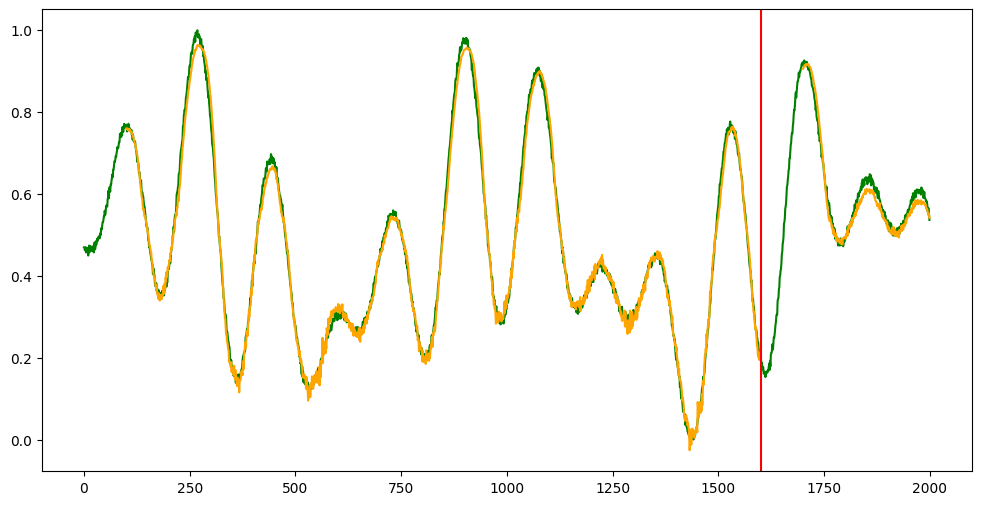

In [11]:
# grafico relativo all'output del modello rispetto
# ai dati reali iniziali
index = df.index.values
plt.figure(figsize=(12, 6))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_rnn) + step)]
plt.plot(x_train_preds, train_predict_rnn, color='orange')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_rnn))]
plt.plot(x_test_preds, test_predict_rnn, color='orange')

plt.axvline(df.index[test_split_point], c='r')
plt.show() 

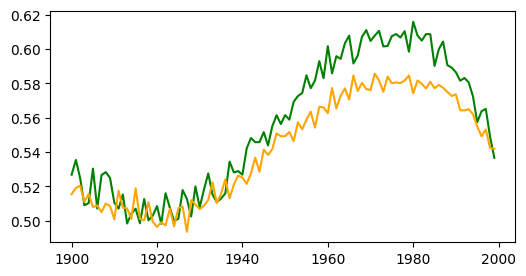

In [12]:
# grafico relativo all'output del modello rispetto
# ai dati reali iniziali - osservazione degli ultimi 100 esempi
plt.figure(figsize=(6, 3))
plt.plot(df[-100:], color='green')
plt.plot(x_test_preds[-100:], test_predict_rnn[-100:], color='orange')
plt.show()

# LSTM

In [13]:
# costruzione del modello tramite celle LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=64, input_shape=(step, 1), return_sequences=True))
model_lstm.add(LSTM(units=64, return_sequences=True))
model_lstm.add(LSTM(units=64,))
model_lstm.add(Dense(32, activation="relu"))
model_lstm.add(Dense(32, activation="relu"))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer=Nadam(), metrics=['mean_absolute_error'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           16896     
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 86,113
Trainable params: 86,113
Non-trai

**Analisi dei parametri**

L'analisi dimensionale in questo contesto è praticamente identica a quella di prima, con la differenza che **prima avevamo:**

```
- SimpleRNN (64) = 4224
- SimpleRNN (64) = 8256
- SimpleRNN (64) = 8256
- Dense (32) = 2080
- Dense (32) = 1056
- Dense (1) = 33

> TOTALE: 23,905
```

Con questo nuovo modello, abbiamo una struttura molto simile, con la differenza che i primi 3 blocchi ora sono LSTM invece che SimpleRNN

\

Con la LSTM, l'analisi dimensionale è la stessa fatto per il SimpleRNN con la differenza principale con la LSTM abbiamo 5 nuovi blocchi:

```
- Cell State
- Gate di Input
- Gate di Output
- Gate di Forget
- Gate di Update
```

tra questi, il Cell State è l'unico che non ha bisogno di paramentri perché fa solo somme e moltipicazioni tra valori "rozzi", tutti gli stati hanno una matrice di pesi associata, quindi con le LTSTM si hanno 4 volte il numero di parametri che si avevano con le RNN.

\

Con le RNN avevamo un numero di parametri pari alla somma di:

\
```
- numero parametri W(input) = (n°celle*n°features)
- numero parametri W(ricorrent) =(n°celle x n°celle)
- numero prametri B = (n°celle x 1)
```

**Con le LSTM tutto sarà moltiplicato per 4:**

```
- numero parametri W(input) = 4 x (n°celle*n°features)
- 4 x numero parametri W(ricorrent) = 4 x (n°celle x n°celle)
- numero prametri B = 4 x (n°celle x 1)
```

Mentre la parte di Dense, resterà inalterata. 

**Quindi otteniamo:**

```
- LSTM (64) = 4 x 4224 = 16896
- LSTM (64) = 4 x 8256 = 33024
- LSTM (64) = 4 x 8256 = 33024
- Dense (32) = 2080
- Dense (32) = 1056
- Dense (1) = 33

> TOTALE = 86,113
```

In [14]:
# addestramento del modello basato su celle LSTM
start = timer()
lstm_h = model_lstm.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
lstm_t = end - start
print('terminato.')

Epoch 1/10
3/3 - 12s - loss: 0.2733 - mean_absolute_error: 0.4646 - 12s/epoch - 4s/step
Epoch 2/10
3/3 - 3s - loss: 0.1839 - mean_absolute_error: 0.3743 - 3s/epoch - 1s/step
Epoch 3/10
3/3 - 3s - loss: 0.0560 - mean_absolute_error: 0.1824 - 3s/epoch - 1s/step
Epoch 4/10
3/3 - 4s - loss: 0.0166 - mean_absolute_error: 0.1079 - 4s/epoch - 1s/step
Epoch 5/10
3/3 - 5s - loss: 0.0143 - mean_absolute_error: 0.1000 - 5s/epoch - 2s/step
Epoch 6/10
3/3 - 6s - loss: 0.0123 - mean_absolute_error: 0.0927 - 6s/epoch - 2s/step
Epoch 7/10
3/3 - 6s - loss: 0.0104 - mean_absolute_error: 0.0843 - 6s/epoch - 2s/step
Epoch 8/10
3/3 - 6s - loss: 0.0086 - mean_absolute_error: 0.0768 - 6s/epoch - 2s/step
Epoch 9/10
3/3 - 3s - loss: 0.0074 - mean_absolute_error: 0.0700 - 3s/epoch - 1s/step
Epoch 10/10
3/3 - 4s - loss: 0.0060 - mean_absolute_error: 0.0634 - 4s/epoch - 1s/step
terminato.


In [15]:
# analisi del comportamento del modello
train_predict_lstm = model_lstm.predict(train_x)
test_predict_lstm = model_lstm.predict(test_x)

10/10 [==============================] - 0s 43ms/step


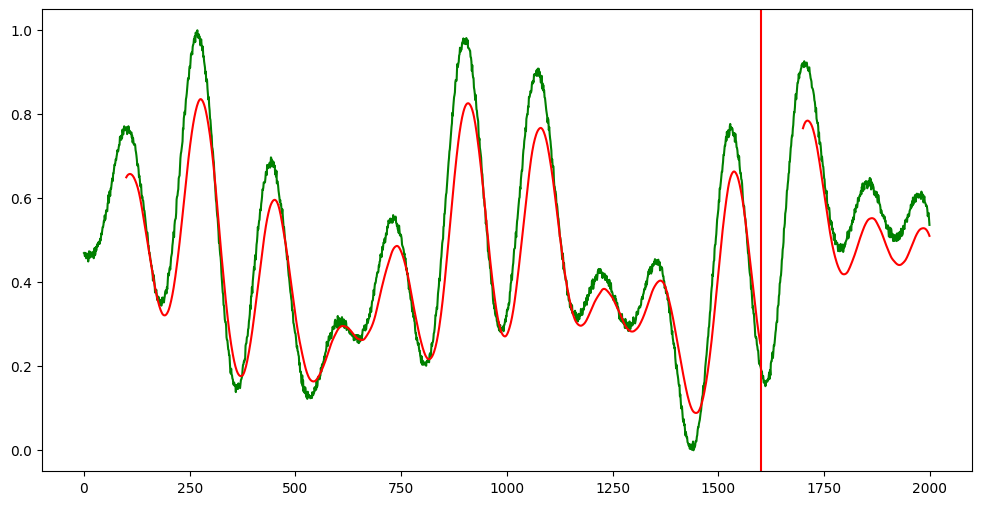

In [16]:
# confronto del comportamento del modello
# rispetto ai dati reali
index = df.index.values
plt.figure(figsize=(12, 6))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_lstm) + step)]
plt.plot(x_train_preds, train_predict_lstm, color='red')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_lstm))]
plt.plot(x_test_preds, test_predict_lstm, color='red')

plt.axvline(df.index[test_split_point], c='r')
plt.show()

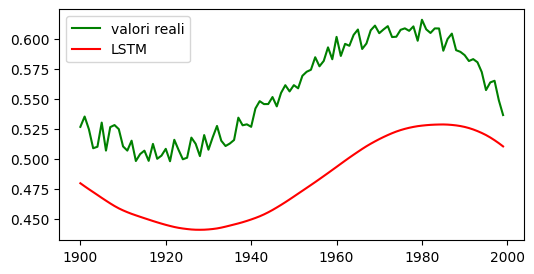

In [17]:
# analisi sugli ultimi 100 esempi predetti rispetto
# ai dati reali iniziali
plt.figure(figsize=(6, 3))
plt.plot(df[-100:], color='green', label='valori reali')
plt.plot(x_test_preds[-100:], test_predict_lstm[-100:], color='red', label='LSTM')
plt.legend()
plt.show()

# GRU

In [18]:
# costruzione di un modello basato su celle di tipo GRU
model_gru = Sequential()
model_gru.add(GRU(units=64, input_shape=(step, 1), return_sequences=True))
model_gru.add(GRU(units=64, return_sequences=True))
model_gru.add(GRU(units=64))
model_gru.add(Dense(32, activation="relu"))
model_gru.add(Dense(32, activation="relu"))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer=Nadam(), metrics=['mean_absolute_error'])
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 64)           12864     
                                                                 
 gru_1 (GRU)                 (None, 100, 64)           24960     
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 65,953
Trainable params: 65,953
Non-trai

**Analisi dei parametri**


L'analisi dimensionale delle GRU è simile a quella fatta sulle LSTM, ci sono un paio di 'però' importanti da considerare.

\

Abbiamo detto che i blocchi LSTM hanno 4 volte i parametri dei bei blocchi SimpleRNN e questo è dovuto alla presenza dei 4 gate in più che aggiungono ognuno un ma matrice di parametri (come fosse una singola SimpleRNN)

\

Nel caso delle GRU, abbiamo una "semplicificazione" della LSTM e un gate in meno che aggiunge parametri, infatti l'architettura GRU combina il Forget Gate e l'Input Gate della SimpleRNN in un unico UpdateGate.

\

Per questo motivo, non avremmo 4 volte i parametri della SimpleRNN ma 3 volte i parametri della SimpleRNN.

\

Se facciamo i conti con i dati del summary() sopra però, questo sembra non tornare, infatti:

```
SimpleRNN (64) = 4224

e dunque

3 x 4224 = 12,672
```

Mentre sopra abbiamo 


```
GRU(64) = 12,864     

```

Con una differenza di 192 parametri in più rispetto ai nostri calcoli.

Questo avviene perché alcuni framework (tra cui keras), hanno deciso di over-parametizzare l'arichetettura, aggiungendo un numero doppio di bias.

\

Dunque **invece di avere:**

```
3 x (n°celle*n°features) = 3 x 64 x 1 = 192
3 x (n°celle x n°celle) = 3 x 64 x 64 = 12,288
3 x (n°celle x 1) = 3 x 64 x 1 = 192
--
TOTALE
192 + 12,288 + 192 = 12,672
```

**abbiamo**
```
4 x (n°celle*n°features) =  3 x 64 x 1 = 192
4 x (n°celle x n°celle) = 3 x 64 x 64 = 12,288
4 x (n°celle x 2) = 3 x 64 x 2 = 384
--
TOTALE
192 + 12,288 + 384 = 12,864
```

Che torna con quanto ottenuto da model.summary()


Per approfondire la qestione del perché keras aggiunge il doppio dei bias, si possono trovare riferimenti a questi link:

- https://github.com/tensorflow/tensorflow/issues/43960

- https://stats.stackexchange.com/questions/328926/how-many-parameters-are-in-a-gated-recurrent-unit-gru-recurrent-neural-network

\

Quindi a questo punto, l'analisi dei parametri sarà la stessa fatta in precendeza con la LSTM, considerndo però 3 volte i parametri della SimpleRNN invece che 4 volte (come fatto per la LSTM) e aggiungendo un altro "strato" di bias per tenere conto della over-parametrizzazione di keras

\

Quindi, riprendendo l'analisi della SimpleRNN in cui abbiamo:

\

L'analisi dimensionale in questo contesto è praticamente identica a quella di prima, con la differenza che **prima avevamo:**

```
- SimpleRNN (64) = 4224
- SimpleRNN (64) = 8256
- SimpleRNN (64) = 8256
- Dense (32) = 2080
- Dense (32) = 1056
- Dense (1) = 33
--
> TOTALE: 23,905
```

Allora **con la GRU otteniano:**
```
- GRU(64) = (3 x 4224) + (3 x 64) = 12,864
- GRU (64) = (3 x 8256) + (3 x 64) = 24,960
- GRU (64) = (3 x 8256) + (3 x 64) = 24,960
- Dense (32) = 2080
- Dense (32) = 1056
- Dense (1) = 33
--
> TOTALE: 65,953
```

In [19]:
# addestramento del modello basato su celle GRU
start = timer()
gru_h = model_gru.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
gru_t = end - start
print('terminato.')

Epoch 1/10
3/3 - 13s - loss: 0.2138 - mean_absolute_error: 0.4104 - 13s/epoch - 4s/step
Epoch 2/10
3/3 - 3s - loss: 0.1414 - mean_absolute_error: 0.3266 - 3s/epoch - 878ms/step
Epoch 3/10
3/3 - 3s - loss: 0.0529 - mean_absolute_error: 0.1812 - 3s/epoch - 853ms/step
Epoch 4/10
3/3 - 4s - loss: 0.0096 - mean_absolute_error: 0.0827 - 4s/epoch - 1s/step
Epoch 5/10
3/3 - 4s - loss: 0.0093 - mean_absolute_error: 0.0843 - 4s/epoch - 1s/step
Epoch 6/10
3/3 - 3s - loss: 0.0069 - mean_absolute_error: 0.0726 - 3s/epoch - 854ms/step
Epoch 7/10
3/3 - 3s - loss: 0.0057 - mean_absolute_error: 0.0658 - 3s/epoch - 876ms/step
Epoch 8/10
3/3 - 3s - loss: 0.0047 - mean_absolute_error: 0.0590 - 3s/epoch - 877ms/step
Epoch 9/10
3/3 - 4s - loss: 0.0037 - mean_absolute_error: 0.0517 - 4s/epoch - 1s/step
Epoch 10/10
3/3 - 3s - loss: 0.0028 - mean_absolute_error: 0.0451 - 3s/epoch - 854ms/step
terminato.


In [20]:
# analisi dell'output del modello
train_predict_gru = model_gru.predict(train_x)
test_predict_gru = model_gru.predict(test_x)

10/10 [==============================] - 0s 36ms/step


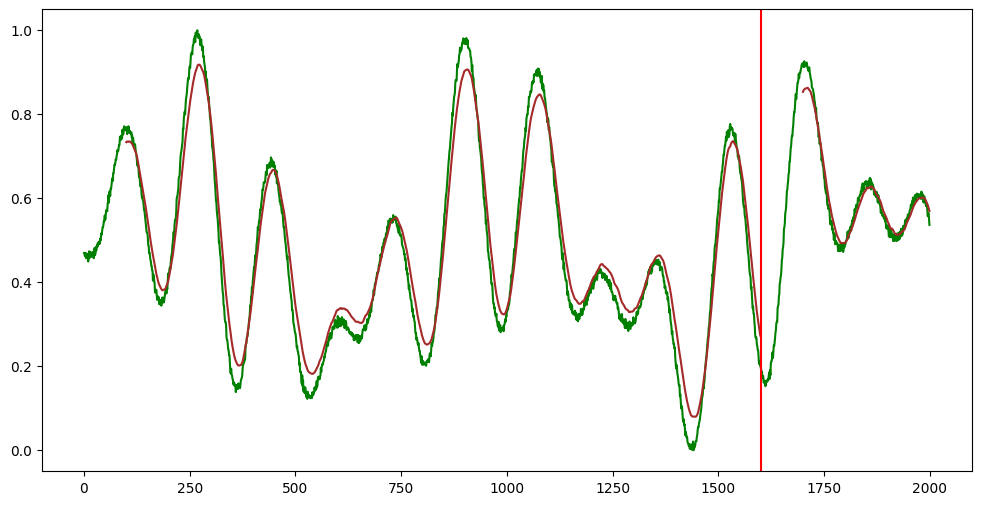

In [21]:
# grafico di confronto dell'output del modello
# rispetto ai dati iniziali
index = df.index.values
plt.figure(figsize=(12, 6))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_gru) + step)]
plt.plot(x_train_preds, train_predict_gru, color='brown')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_gru))]
plt.plot(x_test_preds, test_predict_gru, color='brown')

plt.axvline(df.index[test_split_point], c='r')
plt.show()

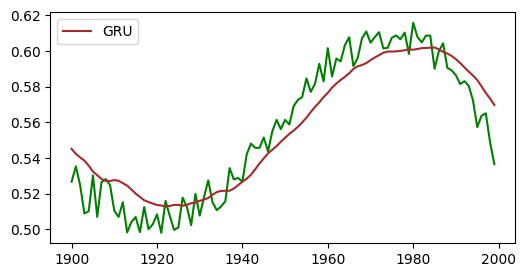

In [22]:
# grafico di dettaglio degli ultimi 100 esempi
# generati dal modello attuale rispetto ai precedenti
plt.figure(figsize=(6, 3))
plt.plot(df[-100:], color='green')
plt.plot(x_test_preds[-100:], test_predict_gru[-100:], color='brown', label='GRU')
plt.legend()
plt.show()

# Vanilla

In [23]:
# implementazione di un modello di base di rete ricorrente
model_vanilla = Sequential()
model_vanilla.add(SimpleRNN(units=64, input_shape=(step, 1), activation="relu"))
model_vanilla.add(Dense(32, activation="relu"))
model_vanilla.add(Dense(1))
model_vanilla.compile(loss='mean_squared_error', optimizer=Nadam(), metrics=['mean_absolute_error'])
model_vanilla.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________


**Analisi dei parametri**

L'analidi dei parametri in questo caso è praticamente uguale alla prima sulla SimpleRNN, con la differenza che abbiamo meno blocchi (e quindi meno paraemntri)

I paramente del primo blocco comunque sono gli stessi e lo stesso vale per le dense successive

In [24]:
# addestramento della vanilla RNN
start = timer()
vanilla_h = model_vanilla.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
vanilla_t = end - start
print('terminato.')

Epoch 1/10
3/3 - 2s - loss: 0.1578 - mean_absolute_error: 0.3525 - 2s/epoch - 733ms/step
Epoch 2/10
3/3 - 0s - loss: 0.0850 - mean_absolute_error: 0.2520 - 283ms/epoch - 94ms/step
Epoch 3/10
3/3 - 0s - loss: 0.0178 - mean_absolute_error: 0.0974 - 278ms/epoch - 93ms/step
Epoch 4/10
3/3 - 0s - loss: 0.0013 - mean_absolute_error: 0.0319 - 280ms/epoch - 93ms/step
Epoch 5/10
3/3 - 0s - loss: 8.0504e-04 - mean_absolute_error: 0.0247 - 283ms/epoch - 94ms/step
Epoch 6/10
3/3 - 0s - loss: 7.5050e-04 - mean_absolute_error: 0.0222 - 257ms/epoch - 86ms/step
Epoch 7/10
3/3 - 0s - loss: 0.0010 - mean_absolute_error: 0.0274 - 259ms/epoch - 86ms/step
Epoch 8/10
3/3 - 0s - loss: 2.3763e-04 - mean_absolute_error: 0.0123 - 274ms/epoch - 91ms/step
Epoch 9/10
3/3 - 0s - loss: 1.7038e-04 - mean_absolute_error: 0.0103 - 285ms/epoch - 95ms/step
Epoch 10/10
3/3 - 0s - loss: 1.5226e-04 - mean_absolute_error: 0.0098 - 275ms/epoch - 92ms/step
terminato.


In [25]:
# validazione della vanilla RNN
train_predict_vanilla = model_vanilla.predict(train_x)
test_predict_vanilla = model_vanilla.predict(test_x)

10/10 [==============================] - 0s 7ms/step


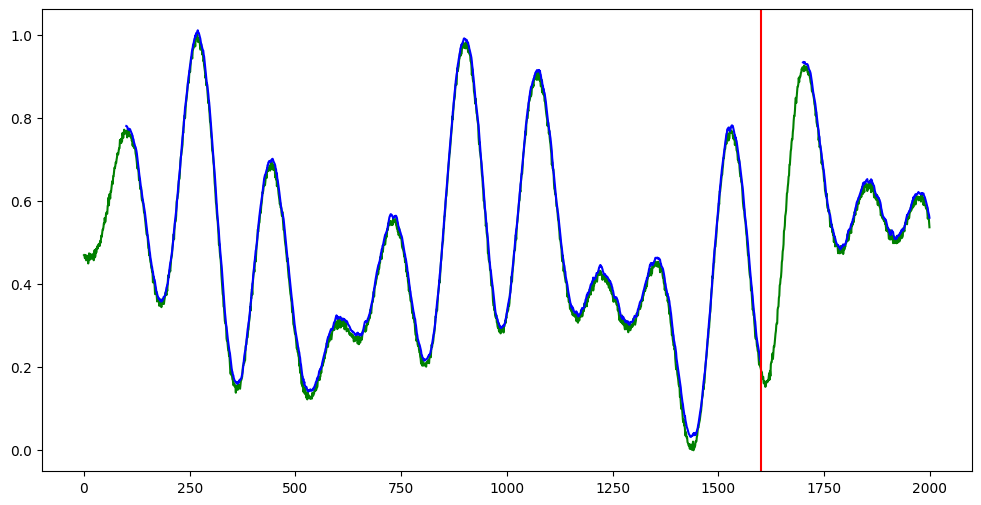

In [26]:
# grafico del confronto tra valori
# predetti e valori reali
index = df.index.values
plt.figure(figsize=(12, 6))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_vanilla) + step)]
plt.plot(x_train_preds, train_predict_vanilla, color='blue')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_vanilla))]
plt.plot(x_test_preds, test_predict_vanilla, color='blue')

plt.axvline(df.index[test_split_point], c='r')
plt.show()

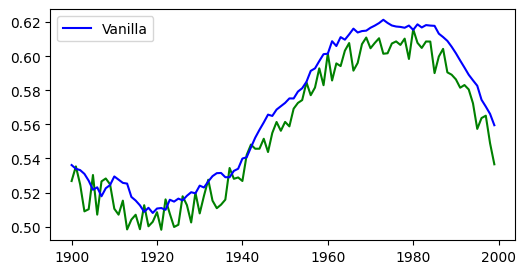

In [27]:
# confronto tra tutti i modelli creati e i dati reali
# per gli ultimi 100 esempi
plt.figure(figsize=(6, 3))
plt.plot(df[-100:], color='green')
plt.plot(x_test_preds[-100:], test_predict_vanilla[-100:], color='blue', label='Vanilla')
plt.legend()
plt.show()

# Comparison


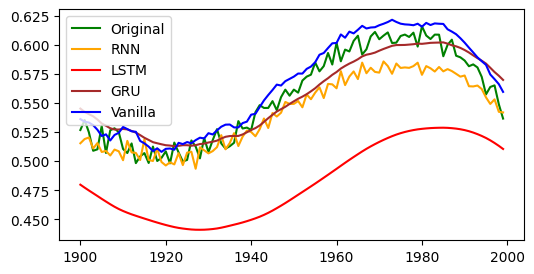

In [28]:
# confronto tra tutti i modelli creati e i dati reali
# per gli ultimi 100 esempi
plt.figure(figsize=(6, 3))
plt.plot(df[-100:], color='green', label='Original')
plt.plot(x_test_preds[-100:], test_predict_rnn[-100:], color='orange', label='RNN')
plt.plot(x_test_preds[-100:], test_predict_lstm[-100:], color='red', label='LSTM')
plt.plot(x_test_preds[-100:], test_predict_gru[-100:], color='brown', label='GRU')
plt.plot(x_test_preds[-100:], test_predict_vanilla[-100:], color='blue', label='Vanilla')
plt.legend()
plt.show()

<Figure size 2000x1200 with 0 Axes>

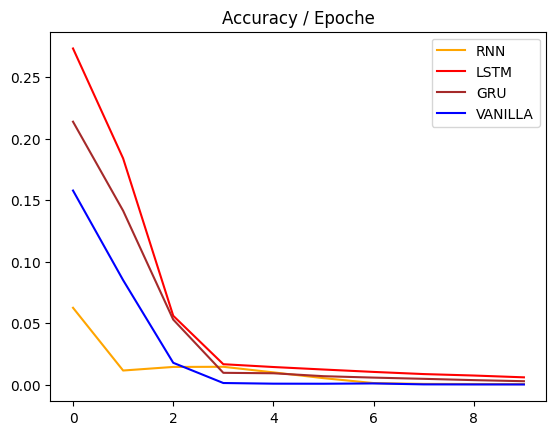

In [29]:
# andamento della Loss tra i vari modelli
plt.figure(figsize=(20,12))
f, ax = plt.subplots()
ax.set_title('Accuracy / Epoche')
ax.plot(rnn_h.history['loss'], color='orange')
ax.plot(lstm_h.history['loss'], color='red')
ax.plot(gru_h.history['loss'], color='brown')
ax.plot(vanilla_h.history['loss'], color='blue')
ax.legend(['RNN', 'LSTM', 'GRU', 'VANILLA'], loc = 0)
plt.show() 

<Figure size 2000x1200 with 0 Axes>

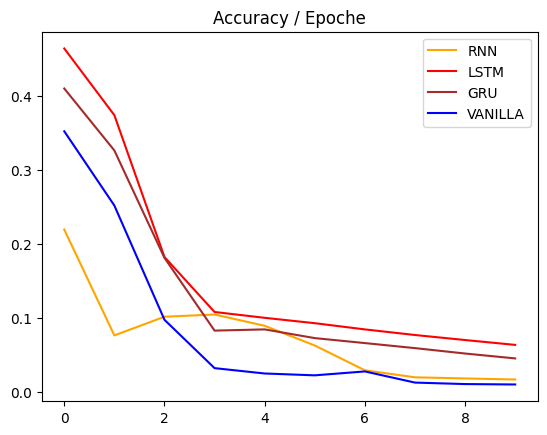

In [30]:
# andamento della Mean Absolute Error tra i vari modelli
plt.figure(figsize=(20,12))
f, ax = plt.subplots()
ax.set_title('Accuracy / Epoche')
ax.plot(rnn_h.history['mean_absolute_error'], color='orange')
ax.plot(lstm_h.history['mean_absolute_error'], color='red')
ax.plot(gru_h.history['mean_absolute_error'], color='brown')
ax.plot(vanilla_h.history['mean_absolute_error'], color='blue')
ax.legend(['RNN', 'LSTM', 'GRU', 'VANILLA'], loc = 0)
plt.show() 

In [31]:
print('          loss      mae     time')
print('LSTM    ', str(lstm_h.history['loss'][len(lstm_h.history['loss'])-1])[:5], '  ', str(lstm_h.history['mean_absolute_error'][len(lstm_h.history['mean_absolute_error'])-1])[:5],
      '   ' + str(lstm_t)[:5])
print('GRU     ', str(gru_h.history['loss'][len(gru_h.history['loss'])-1])[:5], '  ', str(gru_h.history['mean_absolute_error'][len(gru_h.history['mean_absolute_error'])-1])[:5],
      '   ' + str(gru_t)[:5])
print('RNN     ', str(rnn_h.history['loss'][len(rnn_h.history['loss'])-1])[:5], '  ', str(rnn_h.history['mean_absolute_error'][len(rnn_h.history['mean_absolute_error'])-1])[:5],
      '    ' + str(rnn_t)[:4])
print('VANILLA ', str(vanilla_h.history['loss'][len(vanilla_h.history['loss'])-1])[:5], '  ', 
      str(vanilla_h.history['mean_absolute_error'][len(vanilla_h.history['mean_absolute_error'])-1])[:5], '    ' + str(vanilla_t)[:4])

          loss      mae     time
LSTM     0.005    0.063    52.86
GRU      0.002    0.045    49.10
RNN      0.000    0.016     25.4
VANILLA  0.000    0.009     7.10
